In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;} </style>""")

In [2]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
from datetime import datetime, timedelta
print("Libraries imported correctly")
# Necessary imports
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import quantstats as qs
# import statistics as st
# from datetime import datetime, timedelta
# from matplotlib.colors import DivergingNorm
# from scipy.signal import convolve2d
# import import_ipynb
# import Functions



Libraries imported correctly


In [3]:
# Settings for plot visualization
qs.extend_pandas()
plt.rcParams['figure.figsize'] = (20,6) # (26,12)

for_github = False
if for_github:
    color = 'k' # Color for GitHub
    plt.rcParams['legend.facecolor'] = 'w'# Color for GitHub
else:
    color = 'w' # Color for me
    plt.rcParams['legend.facecolor'] = '#2f3540' # Color for me

plt.rcParams['text.color'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
plt.rcParams['axes.labelcolor'] = color

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIG_SIZE = 17
plt.rcParams['font.size'] = SMALL_SIZE
plt.rcParams['axes.titlesize'] = BIG_SIZE
plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
plt.rcParams['xtick.labelsize'] = MEDIUM_SIZE
plt.rcParams['ytick.labelsize'] = MEDIUM_SIZE
plt.rcParams['legend.fontsize'] = SMALL_SIZE
plt.rcParams['figure.titlesize'] = BIG_SIZE

np.set_printoptions(edgeitems=40, linewidth=1000)

pd.set_option("display.precision", 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print("Notebook parameters set correctly")

Notebook parameters set correctly


In [4]:
%run Functions.ipynb

In [5]:
ini_equity = 100
commision = 0.000111538462 # 0.001 = 0.1% of the daily return

## Download data from SP500

In [6]:
#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data.shape
from_date = '1950-01-01'

data = data.loc[from_date:, ['Open', 'Close']].copy()
data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.drop(['Open'], axis=1)

(17717, 5)

In [7]:
data.head()

Close  Market_daily_ret
Date                               
1950-01-03  16.66          0.000000
1950-01-04  16.85          0.011405
1950-01-05  16.93          0.004748
1950-01-06  16.98          0.002953
1950-01-09  17.08          0.005889

In [8]:
data.tail()

Close  Market_daily_ret
Date                                     
2020-05-26  2991.770020          0.012289
2020-05-27  3036.129883          0.014827
2020-05-28  3029.729980         -0.002108
2020-05-29  3044.310059          0.004812
2020-06-01  3058.600098          0.004694

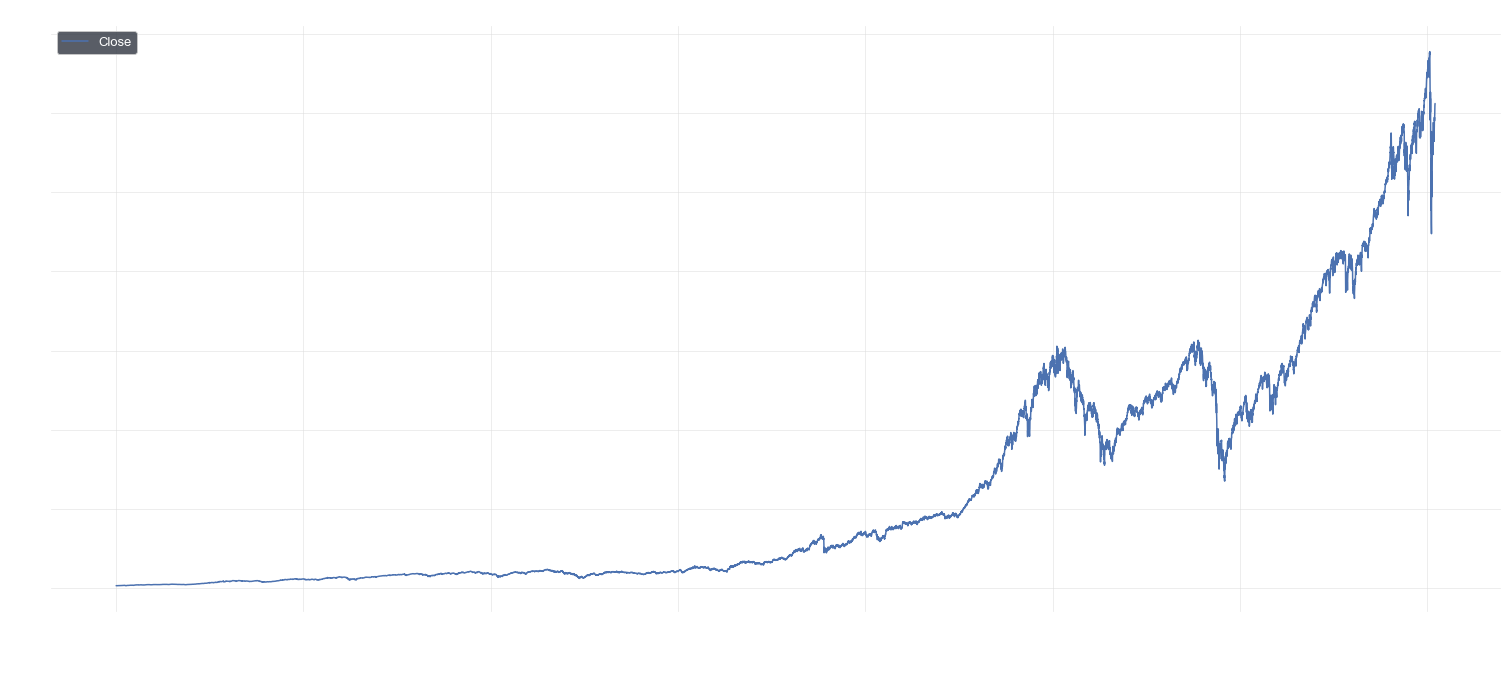

In [9]:
data['Close'].plot(legend=True, title="SP500")

In [10]:
#data.loc['2020', 'Close'].plot(legend=True, title="SP500 in 2020")

## Walk-Forward Optimization

### Define values of Moving Averages and time periods for optimization

In [11]:
%run Functions.ipynb

In [12]:
# fast_ma_list = [1, 3, 5, 10, 15, 20, 25]
# slow_ma_list = [5, 10, 20, 40, 60, 80, 100]

fast_ma_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
slow_ma_list = [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260]

IS_start_years = pd.date_range(start='1950-01-01', end='2017-01-01', freq='1YS', closed=None)
IS_end_years = pd.date_range(start='1952-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start_years = pd.date_range(start='1953-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end_years = pd.date_range(start='1953-12-31', end='2020-12-31', freq='1Y', closed=None)

# IS_start_years = pd.date_range(start='2010-01-01', end='2017-01-01', freq='1YS', closed=None)
# IS_end_years = pd.date_range(start='2012-12-31', end='2019-12-31', freq='1Y', closed=None)
# OOS_start_years = pd.date_range(start='2013-01-01', end='2020-01-01', freq='1YS', closed=None)
# OOS_end_years = pd.date_range(start='2013-12-31', end='2020-12-31', freq='1Y', closed=None)

num_neighbors_matrix = get_num_neighbors(fast_ma_list, slow_ma_list)

len(IS_start_years)
#print_periods(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years)

68

### Optimization

In [13]:
%run Functions.ipynb

In [14]:
%run Functions.ipynb
df = data[IS_start_years[0]:OOS_end_years[-1]].copy()

last_position = 0 # We suppose that we start not being invested. 1:long, -1:short

market_pln = []
oos_pln = []
market_sr = []
oos_sr = []
market_max_dd = []
oos_max_dd = []
best_combinations = []
robust_sharpe_results_list = []

# Create necessary columns 
cols = ['Strat_daily_ret', 'Strat_position', 'Long_only', 'Costs', 'Market_cum_ret']
df = pd.concat([df, pd.DataFrame(columns=cols)])

for IS_start, IS_end, OOS_start, OOS_end in zip(IS_start_years, IS_end_years, OOS_start_years, OOS_end_years):
    results_pnl = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    results_sharpe = np.zeros((len(fast_ma_list),len(slow_ma_list)))

    in_sample = df.loc[IS_start:IS_end].copy()
    oos_sample = df.loc[OOS_start:OOS_end].copy()
    
    ############################################ IN SAMPLE  ############################################
    results_pnl, results_sharpe, market_sharpe = run_all_combinations(in_sample, fast_ma_list, slow_ma_list)
    title = "Individual SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    #show_heatmap(results_sharpe, market_sharpe, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    
    # Get index of maximum SR for the In-Sample period
    fast_index, slow_index, robust_results_sharpe = get_best_combination(market_sharpe, results_sharpe, num_neighbors_matrix, allow_long_only=True)
    title = "Robust SR In Sample ("+str(IS_start.date())+":"+ str(IS_end.date()) +")"
    #show_heatmap(robust_results_sharpe, market_sharpe, plot_title=title, x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
    
    #print("Best In-sample performance:")
    #print_backtest_stats(in_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], ret_strat=results_pnl[fast_index, slow_index], sr_strat=results_sharpe[fast_index, slow_index])
    
    ############################################ OUT OF SAMPLE  ############################################
    #print("OOS performance:")
    _, pnl_sp, sharpe_sp = backtest_ma_strat(oos_sample, fast_ma=0, slow_ma=0, last_position=1) # Market- always long
    _, pnl, sharpe = backtest_ma_strat(oos_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], last_position=last_position)
    #print_backtest_stats(oos_sample, fast_ma_list[fast_index], slow_ma_list[slow_index], pnl, sharpe)  

    ############################################ Save metrics  ############################################
    robust_sharpe_results_list.append(robust_results_sharpe)
    best_combinations.append([fast_ma_list[fast_index], slow_ma_list[slow_index]])
    market_max_dd.append(oos_sample['Market_daily_ret'].max_drawdown())
    oos_max_dd.append(oos_sample['Strat_daily_ret'].max_drawdown())
    market_pln.append(pnl_sp)
    market_sr.append(sharpe_sp)
    oos_pln.append(pnl)
    oos_sr.append(sharpe)
    
    # Save come columns from OOS
    df.loc[OOS_start:OOS_end, cols] = oos_sample[cols]
    #print()

print("End of optimization")

/anaconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:216: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / returns.std()


End of optimization


### Check chosen MA combinations

### Plot OOS of Strategy vs Benchmark

1953  1954  1955  1956  1957  1958  1959  1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020
Fast_ma       3     1     1     1     1     3     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1    25     1     1     1     1     1     1     1     1    65     1    65    65     1    35    30    65     1     0     0     0    35    65     0     1     0     0    50    50    55    50    50     0     0    30    35     5    45    45    50     0    55     0    20    25     1
Slow_ma      20     5     5   140    10    20    20     5     5    10    10    10    10     5     5     5     5     5     5     5     5     5   260     5   100     5     5     5     5     5     5   140   220   180   180    20    40    40   100   260     0     0     0    80   220     0     5     0     0   260   260   220   240   240     0     0   240   220   100   120   120   140     0    60     0    60    40    10
Long_only     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     1     1     0     0     1     0     1     1     0     0     0     0     0     1     1     0     0     0     0     0     0     1     0     1     0     0     0

0    58
1    10
Name: Long_only, dtype: int64

1     33
0     10
65     5
50     5
35     3
55     2
45     2
30     2
25     2
3      2
20     1
5      1
Name: Fast_ma, dtype: int64

5      21
0      10
10      6
220     4
20      4
260     4
240     3
100     3
40      3
140     3
120     2
60      2
180     2
80      1
Name: Slow_ma, dtype: int64

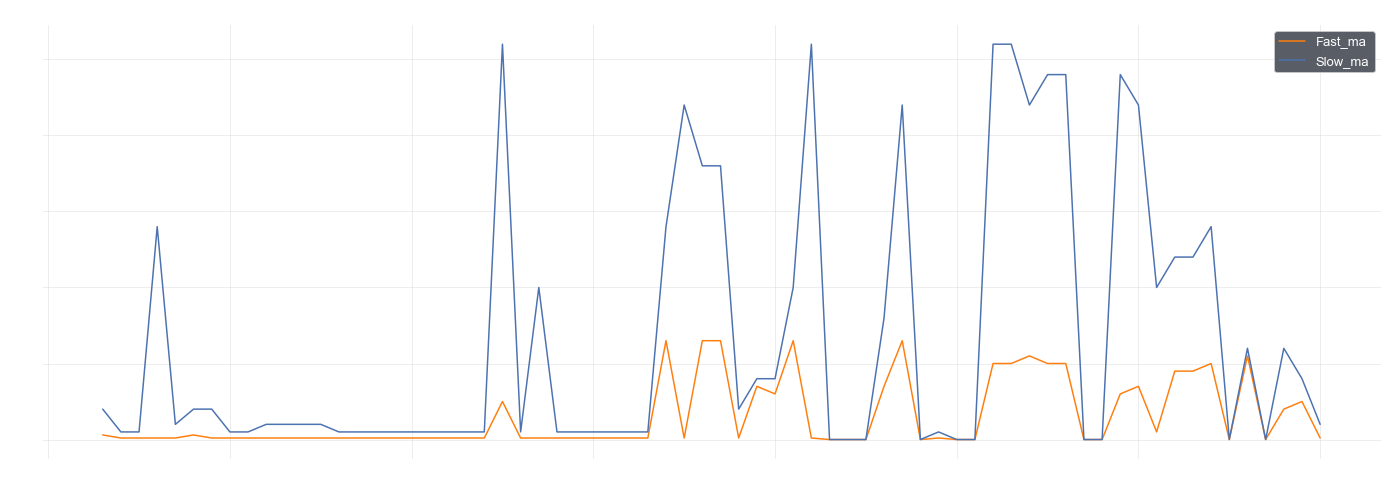

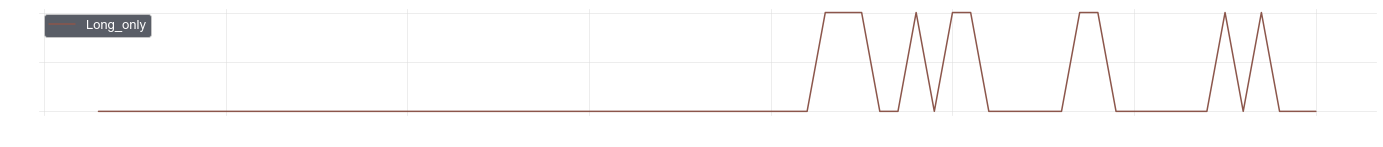

In [15]:
bests = pd.DataFrame(best_combinations, columns=['Fast_ma', 'Slow_ma'], index=OOS_start_years.year)
bests[['Fast_ma', 'Slow_ma']] = bests[['Fast_ma', 'Slow_ma']].where(bests['Fast_ma'] != bests['Slow_ma'], other=0)
bests['Long_only'] = np.where(bests['Fast_ma'] == bests['Slow_ma'], 1, 0)
bests.T
bests['Long_only'].value_counts()
bests['Fast_ma'].value_counts()
bests['Slow_ma'].value_counts()
bests[['Fast_ma', 'Slow_ma']].plot(figsize=(24,8), color=('tab:orange', 'b'), title="Best MA combination chosen")
bests[['Long_only']].plot(figsize=(24,2), color='tab:brown')
#bests.plot(secondary_y=['Long_only'], color=('tab:orange', 'b', 'tab:brown'))

Close  Market_daily_ret  Strat_daily_ret Strat_position Long_only        Costs  Market_cum_ret  Strat_cum_ret
1953-01-02    26.540001         -0.001129        -0.000112              1         0  0.000111538       99.887095      99.988846
2020-06-01  3058.600098          0.004694         0.004694              1         0            0    11511.479612   38786.309717

0    16969
Name: Long_only, dtype: int64

1    11721
0     5248
Name: Strat_position, dtype: int64

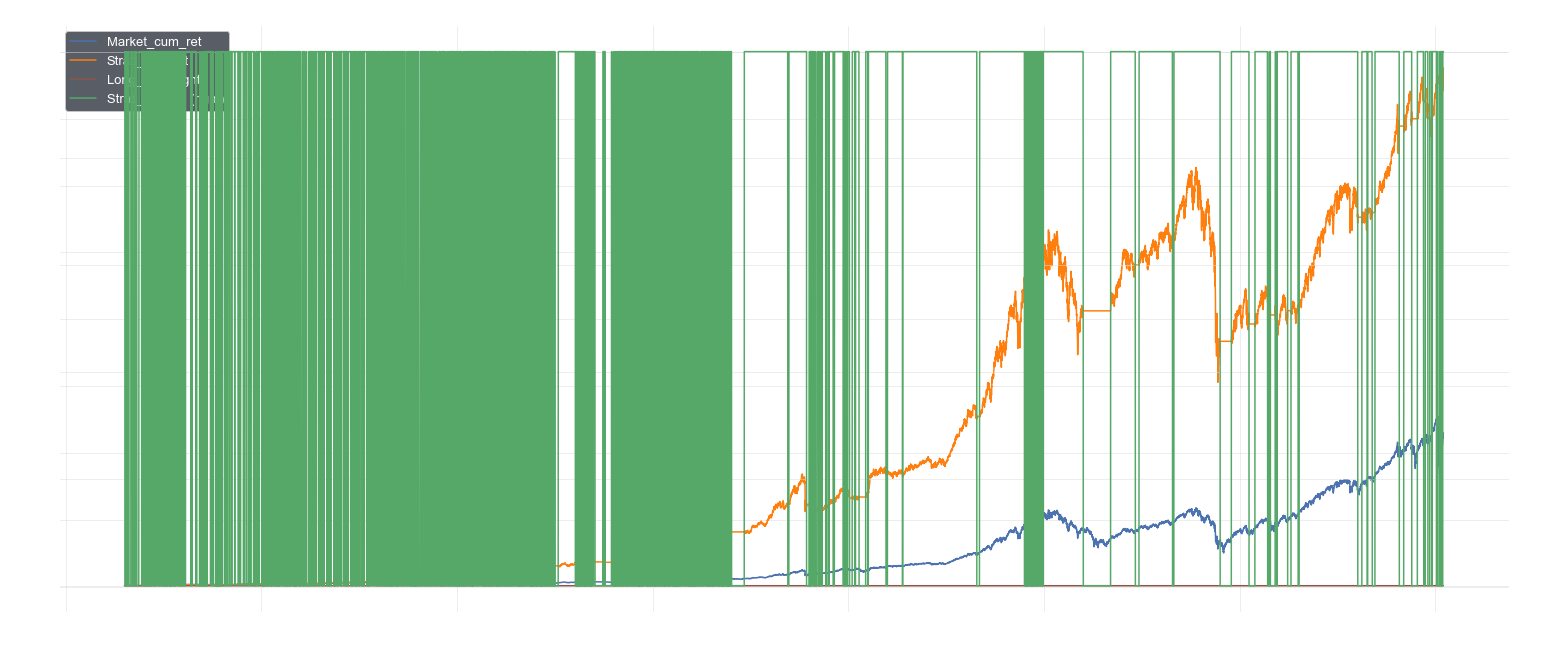

In [16]:
results_df = prepare_oos_df(df.loc[OOS_start_years[0]:OOS_end_years[-1]].copy())
results_df.iloc[[0,-1]]
results_df['Long_only'].value_counts()
results_df['Strat_position'].value_counts()
show_oos_plot(results_df)

### Save metrics from the optimization

In [17]:
results_df.to_csv('Strategy returns.csv')

In [18]:
metrics = ['PNL', 'SR', 'MAX_DD']
index = pd.MultiIndex.from_product([['SP500', 'Strategy']], names=['Asset'])
columns = pd.MultiIndex.from_product([[], metrics], names=['Year', 'Metric'])

metrics_df = pd.DataFrame([], index=index, columns=columns)

for i, year in enumerate(OOS_start_years.year):
    year_sp_pln = market_pln[i]
    year_oos_pln = oos_pln[i]
    year_sp_sr = market_sr[i]
    year_oos_sr = oos_sr[i]
    year_sp_dd = market_max_dd[i]
    year_oos_dd = oos_max_dd[i]
    
    year_data = [[year_sp_pln, year_sp_sr, year_sp_dd], [year_oos_pln, year_oos_sr, year_oos_dd]]
    
    metrics_df = add_data(metrics_df, year_data, year)

metrics_df

Year           1953                            1954                            1955                            1956                           1957                            1958                            1959                            1960                            1961                            1962                            1963                            1964                            1965                            1966                            1967                            1968                            1969                            1970                            1971                            1972                            1973                            1974                            1975                            1976                           1977                            1978                            1979                            1980                           1981                            1982                            1983                      \
Metric          PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD        PNL        SR    MAX_DD         PNL        SR    MAX_DD         PNL        SR    MAX_DD   
Asset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
SP500     93.375987 -0.671338 -0.148162  145.022170  3.999324 -0.044217  126.403558  1.604449 -0.105851  102.616532  0.270385 -0.105963  85.686744 -1.124333 -0.206595  138.059507  3.637708 -0.043570  108.476726  0.909491 -0.091748   97.027886 -0.238671 -0.135618  123.128553  2.124493 -0.062318   88.190071 -0.676879 -0.264445  118.890647  2.058319 -0.065387  112.969880  2.335873 -0.035466  109.061947  1.285378 -0.096045   86.909014 -1.130484 -0.221773  120.092119  2.232168 -0.066093  107.660412  0.923809 -0.093052   88.638549 -1.160846 -0.159759  100.097767  0.081631 -0.258613  110.786755  1.049972 -0.139448  115.633272  1.872231 -0.051355   82.634477 -1.126119 -0.233533   70.281902 -1.500315 -0.375952  131.549016  1.847720 -0.141408  119.148460  1.627096 -0.083650  88.498045 -1.300780 -0.152243  101.062042  0.146459 -0.135527  112.308815  1.120375 -0.102453  125.773570  1.469919 -0.170719  90.269599 -0.690813 -0.183536  114.761319  0.841849 -0.165553  117.271042  1.257962 -0.069068   


Year           1953        1954        1955        1956       1957        1958        1959        1960        1961        1962        1963        1964        1965        1966        1967        1968        1969        1970        1971        1972        1973        1974        1975        1976       1977        1978        1979        1980       1981        1982        1983        1984        1985        1986        1987        1988        1989       1990        1991        1992        1993       1994        1995        1996        1997        1998        1999       2000       2001        2002        2003        2004        2005        2006        2007       2008       2009        2010       2011        2012        2013        2014       2015        2016        2017        2018        2019        2020
Asset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
SP500     93.375987  145.022170  126.403558  102.616532  85.686744  138.059507  108.476726   97.027886  123.128553   88.190071  118.890647  112.969880  109.061947   86.909014  120.092119  107.660412   88.638549  100.097767  110.786755  115.633272   82.634477   70.281902  131.549016  119.148460  88.498045  101.062042  112.308815  125.773570  90.269599  114.761319  117.271042  101.400602  126.333408  114.620409  102.027503  112.400841  127.250465  93.440862  126.306703  104.464263  107.055156  98.460709  134.110655  120.263666  131.008182  126.668589  119.526047  89.860815  86.957307   76.634036  126.380400  108.993452  103.001023  113.619432  103.529573  61.514207  123.45419  112.782714  99.996816  113.405691  129.601250  111.390634  99.273400  109.535023  119.419966   93.762740  128.878070   94.670639
Strategy  98.290534  135.995622  117.234278   93.938309  97.669716  121.258997  105.309000  113.261917  114.503749  118.552237  115.661999  111.918722  110.478287  112.773926  124.723909  121.652098  111.015456  122.482770  124.439617  121.549742  105.071948  104.911288  107.485031  115.636819  93.637211  119.435418  114.930523  127.391401  98.228648  125.987345  105.099610  100.043688  127.747741  116.437435   99.648970   99.000407  118.559661  97.238814  122.275186  102.253566  107.124347  98.663364  134.142430  110.908173  131.656523  126.055639  111.066806  90.717060  89.455211  100.000000  117.075524  103.676820  103.832595  109.128171  103.642258  62.408388  112.99474  101.130197  93.649019  105.227807  125.500215  112.374059  99.296085   98.754746  118.401820  103.408264  105.156503  105.384861

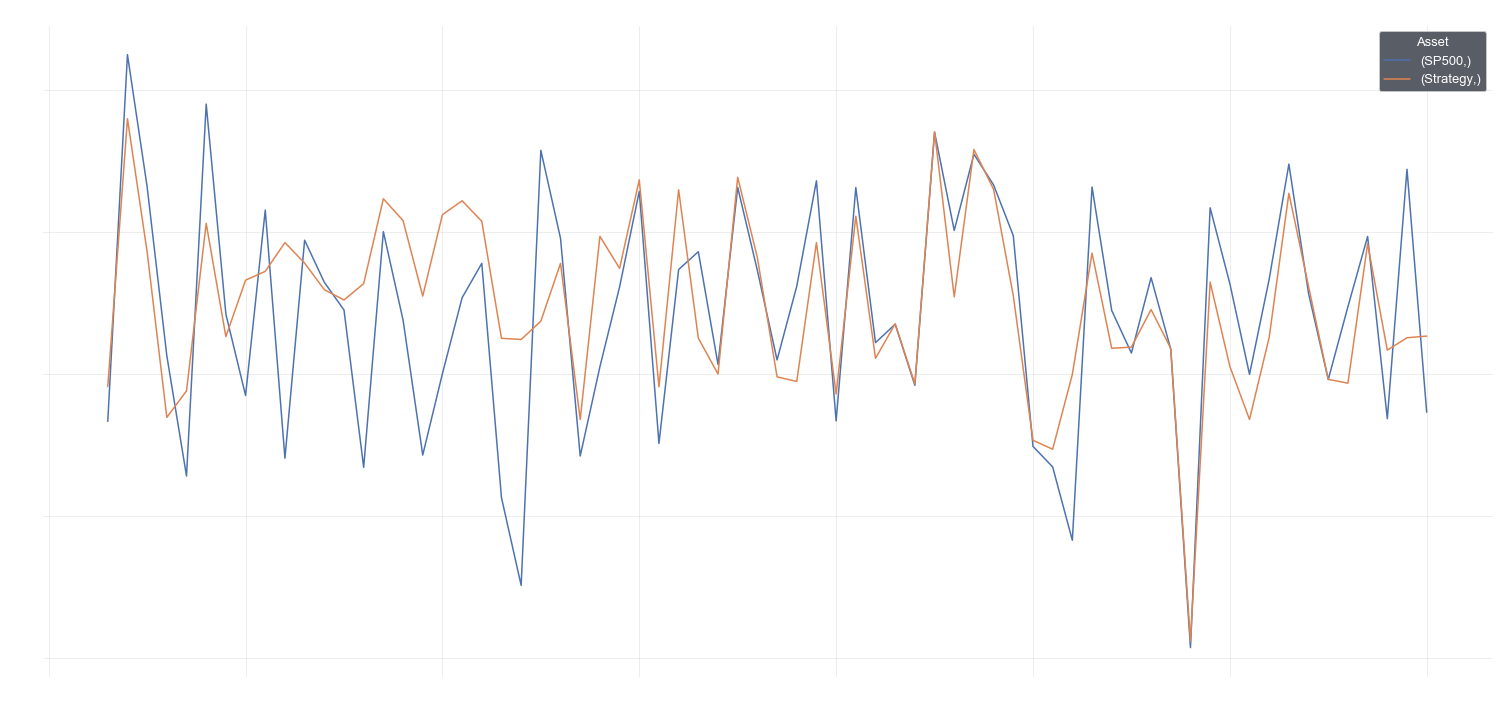

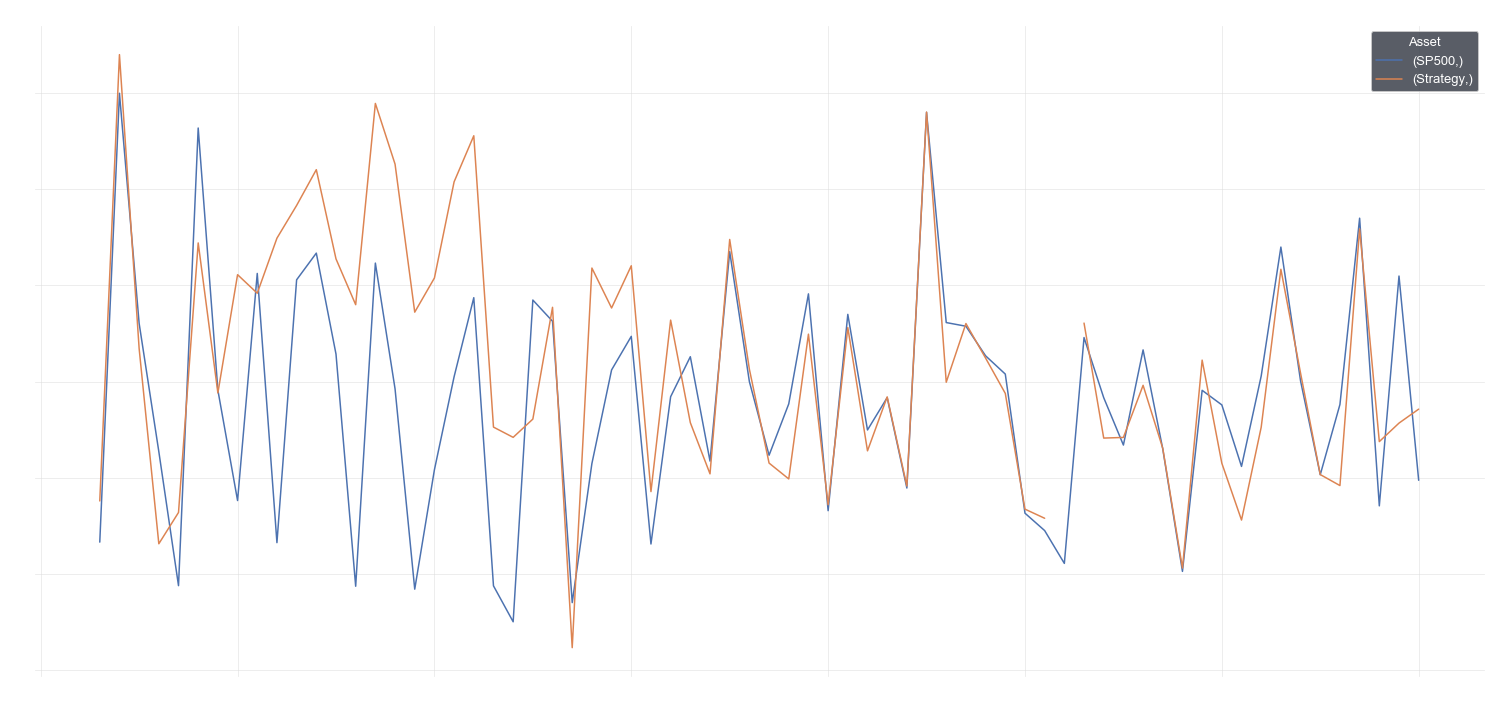

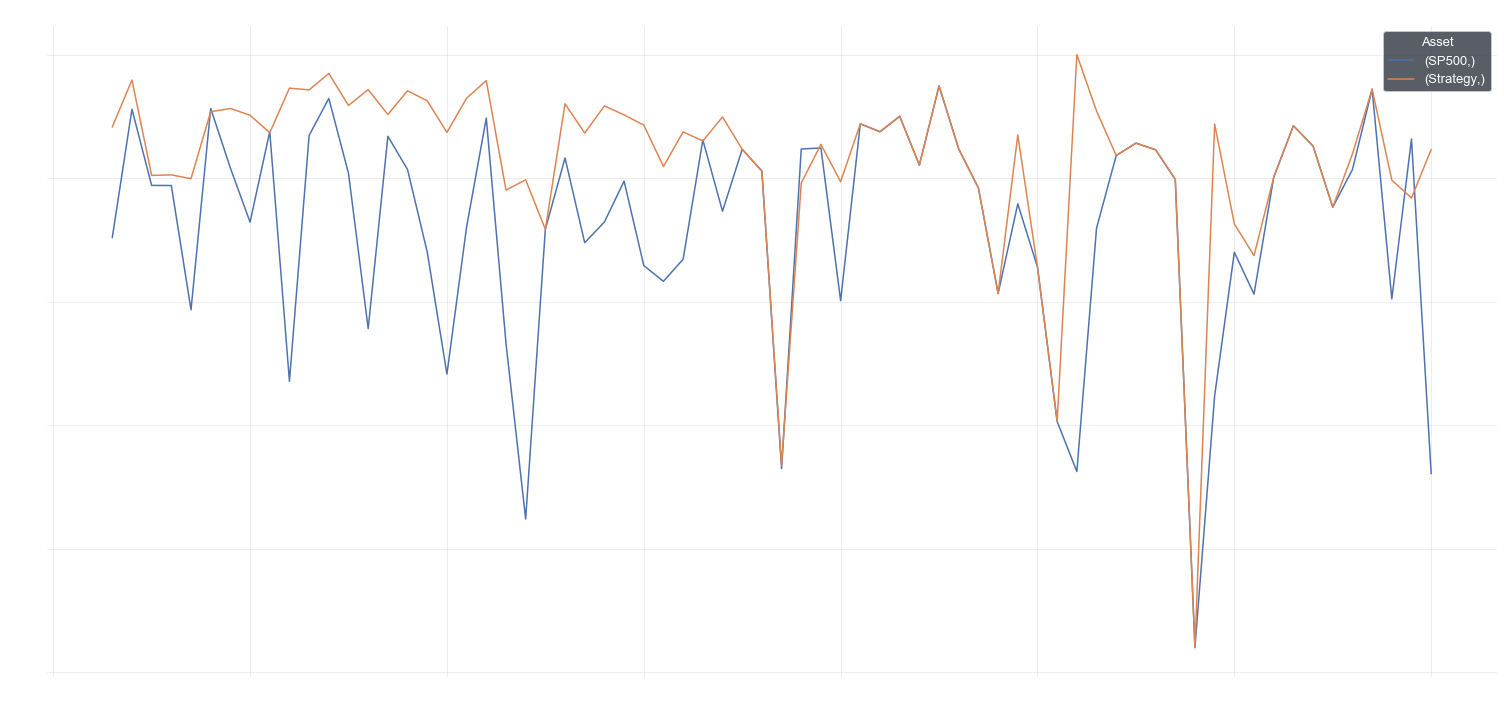

In [19]:
metrics_df.xs('PNL', axis=1, level=1)
metrics_df.xs('PNL', axis=1, level=1).T.plot(title="PNL of Strategy vs Benchmark (1953-2020)")
metrics_df.xs('SR', axis=1, level=1).T.plot(title="SR of Strategy vs Benchmark (1953-2020)")
metrics_df.xs('MAX_DD', axis=1, level=1).T.plot(title="MAX_DD of Strategy vs Benchmark (1953-2020)")

In [20]:
#metrics_df.xs('Strategy', axis=0).round(3).to_clipboard(sep=',')
#metrics_df.xs('Strategy', axis=0).T.sort_index().round(3).to_clipboard(sep=',')
#metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index().round(3).to_clipboard(sep=',')

#metrics_df.round(3).to_csv("metrics.csv", sep=';')

In [21]:
#by column: metrics_df.xs('PNL', axis=1, level='Metric')
#metrics_df.xs('PNL', axis=1, level=1) 
#metrics_df.xs('SP500', axis=0) #by index
#metrics_df.loc['SP500', (2013, 'PNL')]
#met = metrics_df.swaplevel(axis=1).swapaxes(0,1).sort_index()
#met

## Analysis of OOS performance

### HTML Reports 

In [22]:
%run Functions.ipynb
html_df = results_df.copy()
html_df.iloc[[0,-1]]

Close  Market_daily_ret  Strat_daily_ret Strat_position Long_only        Costs  Market_cum_ret  Strat_cum_ret
1953-01-02    26.540001         -0.001129        -0.000112              1         0  0.000111538       99.887095      99.988846
2020-06-01  3058.600098          0.004694         0.004694              1         0            0    11511.479612   38786.309717

#### Strategy

In [23]:
#save_report(html_df['Strat_daily_ret'], benchmark=html_df['Market_daily_ret'])
#save_report(html_df.loc['1953':'1959', 'Strat_daily_ret'], benchmark=html_df.loc['1953':'1959', 'Market_daily_ret'])
#save_report(html_df.loc['1960':'1982', 'Strat_daily_ret'], benchmark=html_df.loc['1960':'1982', 'Market_daily_ret'])
#save_report(html_df.loc['1983':'1999', 'Strat_daily_ret'], benchmark=html_df.loc['1983':'1999', 'Market_daily_ret'])
#save_report(html_df.loc['2000':'2002', 'Strat_daily_ret'], benchmark=html_df.loc['2000':'2002', 'Market_daily_ret'])
#save_report(html_df.loc['2003':'2020', 'Strat_daily_ret'], benchmark=html_df.loc['2003':'2020', 'Market_daily_ret'])
#save_report(html_df.loc['2020':'2020', 'Strat_daily_ret'], benchmark=html_df.loc['2003':'2020', 'Market_daily_ret'])

#### Benchmark

In [26]:
# Report- SP500 ()
#save_report(html_df['Market_daily_ret'], benchmark=html_df['Market_daily_ret'])
#save_report(html_df.loc['1953':'1959', 'Market_daily_ret'], benchmark=html_df.loc['1953':'1959', 'Market_daily_ret'])
#save_report(html_df.loc['1960':'1982', 'Market_daily_ret'], benchmark=html_df.loc['1960':'1982', 'Market_daily_ret'])
#save_report(html_df.loc['1983':'1999', 'Market_daily_ret'], benchmark=html_df.loc['1983':'1999', 'Market_daily_ret'])
#save_report(html_df.loc['2000':'2002', 'Market_daily_ret'], benchmark=html_df.loc['2000':'2002', 'Market_daily_ret'])
#save_report(html_df.loc['2003':'2020', 'Market_daily_ret'], benchmark=html_df.loc['2003':'2020', 'Market_daily_ret'])
#save_report(html_df.loc['2020':'2020', 'Market_daily_ret'], benchmark=html_df.loc['2003':'2020', 'Market_daily_ret'])

###  Overall performance (PNL and SR)

In [25]:
print("Overall OOS performace:")
print("\tMarket\tStrategy\nPNL:\t{:.2f}\t{:.2f}\nSR:\t{:.2f}\t{:.2f}".format(results_df.iloc[-1]['Market_cum_ret'], results_df.iloc[-1]['Strat_cum_ret'], 
                                           results_df['Market_daily_ret'].sharpe(), results_df['Strat_daily_ret'].sharpe()))

print("\nAverage OOS performace: (calculated as the mean of PNL and SR of all years)")
print("\tMarket\tStrategy\nPNL:\t{:.2f}\t{:.2f}\nSR:\t{:.2f}\t{:.2f}".format(np.mean(market_pln), np.mean(oos_pln), 
                                           np.mean(market_sr), np.mean(oos_sr)))

Overall OOS performace:
	Market	Strategy
PNL:	11511.48	38786.31
SR:	0.53	0.78

Average OOS performace: (calculated as the mean of PNL and SR of all years)
	Market	Strategy
PNL:	108.59	109.92
SR:	0.80	nan
